# See Food Project

This project aims in 
* classifying the input image into food categories
* Generate Recipe from the image
* Calorie computation

In [0]:
import torch
import torch.nn as nn
import numpy as np
import os
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output
from PIL import Image
import time
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
 

# Prerequisities

Download the models from the below path:
https://drive.google.com/drive/folders/1i70uNeCJ6z-3akobjnUXyA0r1eeJAuKV?usp=sharing

Note: the link works only for SJSU

In [36]:
!unzip models.zip


Archive:  models.zip
replace models/instr_vocab.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


I am using a image file which i pulled to my collab location

In [0]:
imagePath = 'image-2.jpg'

## Load Food Classification

In [0]:
K.clear_session()
model_path =  'models/best_model_3class.hdf5'
model_best = load_model(model_path, compile=False)

In [0]:
food_list = ['ice_cream','ramen','pad_thai','fried_rice','chicken_curry','hot_and_sour_soup','french_onion_soup']

def predict_class(model, img, show = True):
  
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

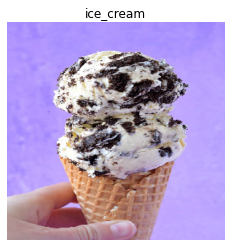

In [40]:
predict_class(model_best, imagePath, True)

# Get Calorie information

In [0]:
def getCalorieInformation(title):
    df = pd.read_csv('models/nutrition.csv',low_memory=False);
    nutrients = df[df['title']==title]['nutr_values_per100g'].tolist()
    return nutrients

# Load Recipe model

In [0]:
use_gpu = False
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [43]:
ingrs_vocab = pickle.load(open('models/ingr_vocab.pkl', 'rb'))
vocab = pickle.load(open('models/instr_vocab.pkl', 'rb'))
title = ''
ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size
t = time.time()
import sys;
sys.argv = [''];
del sys
args = get_parser()
args.maxseqlen = 15
args.ingrs_only = False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
model_path =  'models/modelbest.ckpt'
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False
print('loaded model')
print("Elapsed time:", time.time() - t)

loaded model
Elapsed time: 2.38749623298645


In [0]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [0]:
greedy = [True]
beam = [-1]
temperature = 1.0
numgens = len(greedy)

In [0]:
image = Image.open(imagePath).convert('RGB')
transf_list = []
transf_list.append(transforms.Resize(256))
transf_list.append(transforms.CenterCrop(224))
transform = transforms.Compose(transf_list)
    
image_transf = transform(image)
image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    



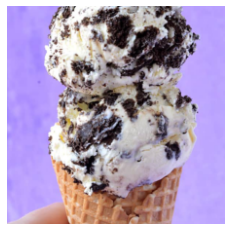

RECIPE 1

Title: Oreo ice cream

Ingredients:
cookie, sugar, butter, cream, milk, extract, egg

Instructions:
-In a large bowl, combine the oreos, butter and sugar.
-Mix until well combined.
-Press into a 9 x 13 inch pan.
-In a medium bowl, beat the egg yolks until thick and pale.
-Add the condensed milk, vanilla and cream.
-Beat until smooth.
-Pour the mixture over the crust.
-Freeze for at least 4 hours or overnight.
-Remove from freezer about 15 minutes before serving.
*** Calorie information *** 
{'energy': 301.1849670174859, 'fat': 14.151372526311448, 'protein': 3.596968035993615, 'salt': 0.109414215320766, 'saturates': 8.142758045734483, 'sugars': 38.46963474919645}


In [48]:
plt.imshow(image_transf)
plt.axis('off')
plt.show()
plt.close()
    
num_valid = 1
for i in range(numgens):
  with torch.no_grad():
        outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        
        if valid['is_valid'] or show_anyways:
            
            print ('RECIPE', num_valid)
            num_valid+=1
            #print ("greedy:", greedy[i], "beam:", beam[i])
    
            BOLD = '\033[1m'
            END = '\033[0m'
            print (BOLD + '\nTitle:' + END,outs['title'])

            print (BOLD + '\nIngredients:'+ END)
            print (', '.join(outs['ingrs']))

            print (BOLD + '\nInstructions:'+END)
            print ('-'+'\n-'.join(outs['recipe']))

            print ('='*20)
            print('*** Calorie information *** ')
            print(getCalorieInformation(outs['title'])[0])

        else:
            pass
            print ("Not a valid recipe!")
            print ("Reason: ", valid['reason'])